# Day 7 


--- Statistics ---
The number of nodes for which you could find genres: 17
The average number of genres per node: 1.29
The total number of distinct genres: 14


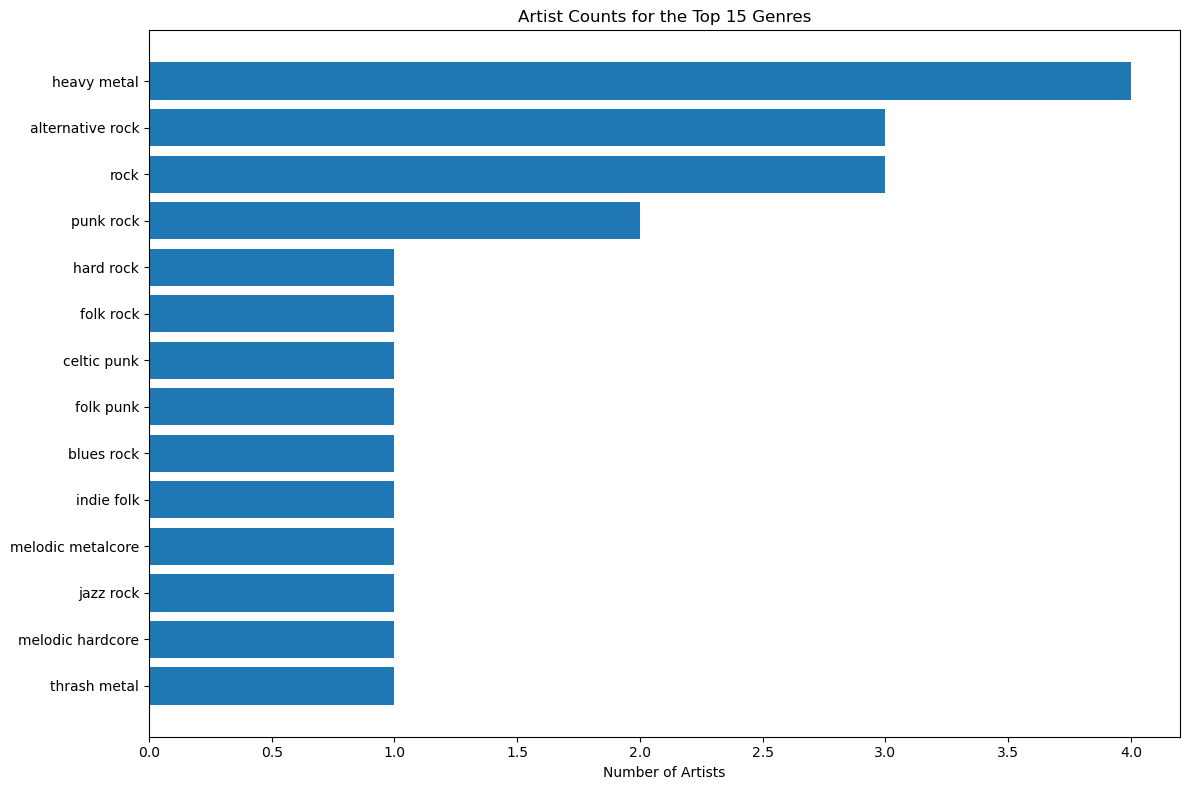

In [14]:
import os
import re
import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def extract_genres_from_wikitext(wikitext):
    """
    Parses wikitext to find and clean genres from a musical artist infobox.
    This function is already correct and does not need changes.
    """
    if not isinstance(wikitext, str):
        return None

    # Search for standard infobox variations for musical artists.
    infobox_match = re.search(r'\{\{(Infobox musical artist|Infobox band)(.*?)\}\}', wikitext, re.DOTALL | re.IGNORECASE)
    if not infobox_match:
        return None

    infobox_content = infobox_match.group(2)

    # Find the genre field within the infobox.
    genre_match = re.search(r'\|\s*genre\s*=\s*(.*?)(?=\n\s*\||\}\})', infobox_content, re.DOTALL | re.IGNORECASE)
    if not genre_match:
        return None

    raw_genres = genre_match.group(1)

    # Clean the extracted genre string.
    raw_genres = re.sub(r'<!--.*?-->', '', raw_genres, flags=re.DOTALL)
    raw_genres = re.sub(r'<ref.*?>.*?</ref>', '', raw_genres, flags=re.DOTALL)
    raw_genres = re.sub(r'<.*?>', '', raw_genres)
    raw_genres = re.sub(r'\[\[(?:[^|\]]*\|)?([^\]]+)\]\]', r'\1', raw_genres)
    raw_genres = re.sub(r'\{\{(?:unbulleted list|flatlist|hlist)\s*\|', '', raw_genres, flags=re.IGNORECASE)
    raw_genres = raw_genres.replace('}}', '')

    genres = re.split(r'[,/\n*]', raw_genres)

    cleaned_genres = []
    for genre in genres:
        genre = genre.strip().lower()
        if genre:
            if 'rock' in genre and ('&' in genre or 'and' in genre) and 'roll' in genre:
                genre = 'rock and roll'
            cleaned_genres.append(genre)

    return cleaned_genres if cleaned_genres else None

# --- Main Script Execution ---

bands_folder_path = r"C:\Users\Madsl\Dropbox\DTU\Kand\2.semester\Socialgraphs_and_interactions\SocialGraphs\SocialGraphs\Assignment1\bands"
artist_genres_map = {}

if not os.path.isdir(bands_folder_path):
    print(f"Error: The directory '{bands_folder_path}' does not exist.")
else:
    # Loop through all files in the directory
    for filename in os.listdir(bands_folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(bands_folder_path, filename)
            artist_name = os.path.splitext(filename)[0].replace('_', ' ')

            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)

                # --- CORRECTED JSON NAVIGATION LOGIC ---
                wikitext = None
                pages = data.get('query', {}).get('pages', {})
                if pages:
                    page_id = next(iter(pages))
                    page = pages[page_id]
                    
                    # This is the corrected path based on your diagnostic output
                    if 'revisions' in page and page['revisions'] and 'slots' in page['revisions'][0]:
                        slots = page['revisions'][0]['slots']
                        if 'main' in slots and '*' in slots['main']:
                             wikitext = slots['main']['*']
                # --- END OF CORRECTION ---

                if wikitext:
                    genres = extract_genres_from_wikitext(wikitext)
                    if genres:
                        artist_genres_map[artist_name] = genres
                        # print(f"SUCCESS: Found genres for {artist_name}: {genres}") # Uncomment for debugging
                    # else:
                        # print(f"NOTE: Could not find genres for {artist_name} in its infobox.") # Uncomment for debugging
                # else:
                    # print(f"WARNING: No wikitext could be extracted from {filename}.") # Uncomment for debugging

            except Exception as e:
                print(f"An unexpected error occurred with file {filename}: {e}")

# --- Reporting Stats ---

if not artist_genres_map:
    print("\n----------------------------------------")
    print("Execution finished. Could not find any genres.")
    print("Please check for any unexpected error messages above.")
else:
    num_nodes_with_genres = len(artist_genres_map)
    total_genres_found = sum(len(g) for g in artist_genres_map.values())
    average_genres_per_node = total_genres_found / num_nodes_with_genres
    all_genres = [genre for genres in artist_genres_map.values() for genre in genres]
    total_distinct_genres = len(set(all_genres))

    print("\n--- Statistics ---")
    print(f"The number of nodes for which you could find genres: {num_nodes_with_genres}")
    print(f"The average number of genres per node: {average_genres_per_node:.2f}")
    print(f"The total number of distinct genres: {total_distinct_genres}")

    # --- Histogram of Top 15 Genres ---
    genre_counts = Counter(all_genres)
    top_15_genres = genre_counts.most_common(15)

    if top_15_genres:
        genres, counts = zip(*top_15_genres)

        plt.figure(figsize=(12, 8))
        y_pos = np.arange(len(genres))
        plt.barh(y_pos, counts, align='center')
        plt.yticks(y_pos, labels=genres)
        plt.gca().invert_yaxis()
        plt.xlabel('Number of Artists')
        plt.title('Artist Counts for the Top 15 Genres')
        plt.tight_layout()
        plt.show()